Удалось получить confusion-матрицу из единиц на диагонали для прилагательных одного склонения. (НОВЫЙ и ХОРОШИЙ)

Теперь хотим собрать одну сеть для предсказания окончания всех склонений.

imports

In [1]:
import ast
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tg.grammar_ru.common import Loc
from tg.grammar_ru.corpus import CorpusReader, CorpusBuilder, BucketCorpusBalancer
from tg.grammar_ru.corpus.corpus_reader import read_data
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv(Loc.root_path / 'environment.env')
from tg.grammar_ru.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.grammar_ru.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer

from yo_fluq_ds import Queryable, Query, fluq
import plotly.express as px
from tg.grammar_ru.common import Separator

from typing import List, Union
import numpy as np
import torch
import math
import pandas as pd
from sklearn.metrics import confusion_matrix
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle
from tg.grammar_ru.components.plain_context_builder import PlainContextBuilder

pd.set_option('display.max_rows', 500)
from analysis_tools import get_training_results, plot_metrics, plot_cm

In [2]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle
from tg.grammar_ru.components.plain_context_builder import PlainContextBuilder
bundle_0_declination_path = Loc.data_cache_path/'bundles/agreement/mid50_0_declination'
bundle_all_declination_path = Loc.data_cache_path/'bundles/agreement/mid50_all_decl'

endings & calculate masks

In [3]:
NEW = {'ая', 'ого', 'ое', 'ой', 'ом', 'ому',
       'ую', 'ые', 'ый', 'ым', 'ыми', 'ых'}
# NOTE выкинули 'ою'

GOOD = {'ая', 'его', 'ее', 'ей', 'ем', 'ему',
        'ие', 'ий', 'им', 'ими', 'их', 'ую', 'яя', 'юю',
        'ого','ое', 'ой', 'ому', 'ом'} # легкий

BIG = {'ая', 'ие', 'им', 'ими', 'их', 'ого',
       'ое', 'ой', 'ом', 'ому', 'ую',
       'ые', 'ым', 'ыми', 'ых'} # золотой
# NOTE выкинули 'ою'

NEW_list = sorted(list(NEW))
GOOD_list = sorted(list(GOOD))
BIG_list = sorted(list(BIG))
# окончания с повторами. это фича.
ALL_ENDS_list = NEW_list + GOOD_list + BIG_list
POSSIBLE_ENDINGS = set(ALL_ENDS_list)
endings_nums = {e: i for i, e in enumerate(ALL_ENDS_list)}

NEW_num_by_end = {e: i for i, e in enumerate(NEW_list)}
GOOD_num_by_end = {e: i+len(NEW_num_by_end) for i, e in enumerate(GOOD_list)}
BIG_num_by_end = {e: i+len(NEW_num_by_end)+len(GOOD_num_by_end)
                  for i, e in enumerate(BIG_list)}

nums_by_decl_and_end = (
    {('new', e): n for e, n in NEW_num_by_end.items()} |
    {('good', e): n for e, n in GOOD_num_by_end.items()} |
    {('big', e): n for e, n in BIG_num_by_end.items()}
)
end_num_df = pd.DataFrame(list((0, e, n) for e, n in NEW_num_by_end.items()) +
                          list((1, e, n) for e, n in GOOD_num_by_end.items()) +
                          list((2, e, n) for e, n in BIG_num_by_end.items()),
                          columns=['declension_type', 'ending', 'n']
                          )
mask_NEW = (end_num_df.declension_type==0).astype(int).values
mask_GOOD = (end_num_df.declension_type==1).astype(int).values
mask_BIG = (end_num_df.declension_type==2).astype(int).values
decl_end_by_num = {n: k for k, n in nums_by_decl_and_end}


In [4]:
masks = pd.DataFrame(np.stack([mask_NEW,mask_GOOD, mask_BIG]), columns=[
    f'mask{i}' for i in range(len(mask_NEW))
])
masks.index.name = 'declension_type'
masks

,mask0,mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8,mask9,...,mask36,mask37,mask38,mask39,mask40,mask41,mask42,mask43,mask44,mask45
declension_type,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [5]:
project_name = 'agreementproject'
# dataset_name = 'agreement_adj_mid50_all_decl_masked'
bucket = 'agreementadjbucket'

## Add masks to bundle

In [6]:
from tg.projects.agreement.bundles_tools import set_mask, upload_bundle


tiny

In [9]:
tiny_all_decl_path = Loc.data_cache_path/f'bundles/agreement/tiny_all_decl'
tiny_all_decl_masked_path = Loc.data_cache_path / \
    f'bundles/agreement/tiny_all_decl_masked'
db_tiny = DataBundle.load(tiny_all_decl_path)
set_mask(tiny_all_decl_path, tiny_all_decl_masked_path, masks)
upload_bundle(tiny_all_decl_masked_path,
              'agreement_adj_tiny_all_decl_masked', bucket, project_name)


mid

In [10]:
mid_all_decl_path = Loc.data_cache_path/f'bundles/agreement/mid50_all_decl'
mid_all_decl_masked_path = Loc.data_cache_path / \
    f'bundles/agreement/mid50_all_decl_masked'
db = DataBundle.load(mid_all_decl_path)
set_mask(mid_all_decl_path, mid_all_decl_masked_path, masks)
upload_bundle(mid_all_decl_masked_path,
              'agreement_adj_mid50_all_decl_masked', bucket, project_name)


In [9]:
mid_masked = DataBundle.load(mid_all_decl_masked_path)

In [11]:
mid_masked.index.head(100).declension_type.value_counts()

2    100
Name: declension_type, dtype: int64

In [37]:
td = db.index[db.index.split.isin(['train','display'])]

In [11]:
# td.head(15)

In [31]:
import eule
diagram = eule.euler({
    'new':list(NEW),
    'good':list(GOOD),
    'big':list(BIG),
                      })
print(diagram)

{'good': ['его', 'ее', 'яя', 'ем', 'ему', 'ий', 'юю', 'ей'], 'big,good': ['ие', 'им', 'ими', 'их'], 'big,good,new': ['ую', 'ая', 'ой', 'ому', 'ого', 'ом', 'ое'], 'big,new': ['ые', 'ым', 'ыми', 'ых'], 'new': ['ый']}


In [3]:
from tg.grammar_ru.features import PyMorphyFeaturizer, SlovnetFeaturizer, SyntaxTreeFeaturizer, SyntaxStatsFeaturizer
from tg.grammar_ru.common import Loc
from yo_fluq_ds import *

from tg.grammar_ru.corpus import CorpusBuilder
from tg.projects.agreement.bundle import AdjAgreementTrainIndexBuilder

In [4]:
BALANCED_PATH = Loc.corpus_path/"prepare/balanced/books&pub_tiny_balanced.zip"
reader = CorpusReader(BALANCED_PATH)


In [20]:
# df =AdjAgreementTrainIndexBuilder().select(_,reader.get_frames().first(),_)[0]

In [21]:
# df[df.is_target]

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


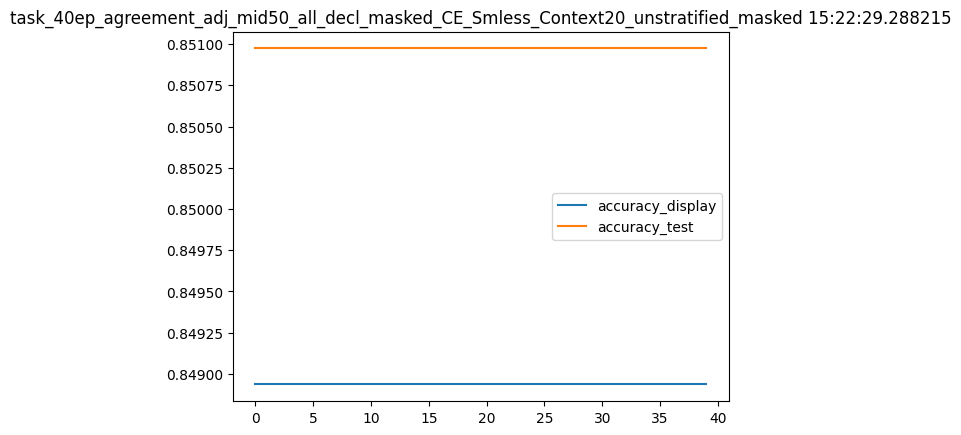

In [15]:
job_name = 'datasphere/agreementproject/job_info/job_agreementproject_15:22:29.288161.txt'
metrics, result_df, y_true, y_pred, tasks = get_training_results(bucket,job_name, project_name)


plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
# cm = pd.DataFrame(
#     confusion_matrix(y_true, y_pred,
#                         # normalize='true'
#                      ).round(2),
#     columns=[f'pred {decl_end_by_num[n]}' for n in sorted_nums],
#     index=[f'actual {decl_end_by_num[n]}' for n in sorted_nums]
# )
# plot_cm(cm)
# cm = pd.DataFrame(
#     confusion_matrix(y_true, y_pred,
#                         normalize='true'
#                      ).round(2),
#     columns=[f'pred {ending_by_num[n]}({n})' for n in sorted_nums],
#     index=[f'actual {ending_by_num[n]}({n})' for n in sorted_nums]
# )
# plot_cm(cm)


In [16]:
sorted(y_true.unique())

[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

In [17]:
sorted(y_pred.unique())


[38]

In [9]:
BIG_num_by_end

{'ая': 31,
 'ие': 32,
 'им': 33,
 'ими': 34,
 'их': 35,
 'ого': 36,
 'ое': 37,
 'ой': 38,
 'ом': 39,
 'ому': 40,
 'ую': 41,
 'ые': 42,
 'ым': 43,
 'ыми': 44,
 'ых': 45}

In [4]:
db = DataBundle.load(Loc.data_cache_path/f'bundles/agreement/mid50_all_decl')

In [11]:
len(db.index[db.index.split=='test'].label.unique())

46

In [19]:
pred_col_names = [c for c in result_df.columns if 'predicted_label' in c ]
true_col_names = [c for c in result_df.columns if 'true_label' in c ]

In [20]:
result_df[pred_col_names]

,predicted_label_38,predicted_label_37,predicted_label_35,predicted_label_36,predicted_label_33,predicted_label_42,predicted_label_32,predicted_label_31,predicted_label_45,predicted_label_41,predicted_label_43,predicted_label_39,predicted_label_34,predicted_label_44,predicted_label_40
sample_id,,,,,,,,,,,,,,,
55,1.0,7.118623e-24,1.161089e-12,1.547536e-12,1.449788e-12,1.284782e-12,1.034543e-13,1.238538e-12,1.157425e-12,5.031924e-38,1.142922e-12,1.118721e-12,1.130348e-12,1.092420e-12,1.057740e-12
62,1.0,7.118515e-24,1.161089e-12,1.547477e-12,1.449811e-12,1.284787e-12,1.034637e-13,1.238547e-12,1.157430e-12,5.032500e-38,1.142935e-12,1.118725e-12,1.130357e-12,1.092429e-12,1.057744e-12
107,1.0,7.118570e-24,1.161018e-12,1.547536e-12,1.449694e-12,1.284760e-12,1.034580e-13,1.238519e-12,1.157408e-12,5.031694e-38,1.142909e-12,1.118697e-12,1.130327e-12,1.092402e-12,1.057716e-12
120,1.0,7.118596e-24,1.161018e-12,1.547548e-12,1.449700e-12,1.284760e-12,1.034578e-13,1.238519e-12,1.157408e-12,5.031732e-38,1.142909e-12,1.118700e-12,1.130327e-12,1.092404e-12,1.057724e-12
127,1.0,7.115745e-24,1.162419e-12,1.546026e-12,1.451703e-12,1.285218e-12,1.035727e-13,1.239001e-12,1.157779e-12,5.046419e-38,1.143343e-12,1.119146e-12,1.130814e-12,1.092852e-12,1.058083e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152249,1.0,7.119709e-24,1.162849e-12,1.547460e-12,1.452055e-12,1.285304e-12,1.033702e-13,1.239015e-12,1.157946e-12,5.036841e-38,1.143241e-12,1.119261e-12,1.130857e-12,1.092893e-12,1.058241e-12
152274,1.0,7.118651e-24,1.161076e-12,1.547501e-12,1.449739e-12,1.284777e-12,1.034614e-13,1.238533e-12,1.157421e-12,5.032155e-38,1.142922e-12,1.118715e-12,1.130346e-12,1.092418e-12,1.057732e-12
152303,1.0,7.118216e-24,1.162578e-12,1.546946e-12,1.451775e-12,1.285243e-12,1.034503e-13,1.238977e-12,1.157845e-12,5.040031e-38,1.143262e-12,1.119182e-12,1.130805e-12,1.092845e-12,1.058148e-12


Странно. В result_df нет даже колонок predicted_label_1..30

TINY


output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


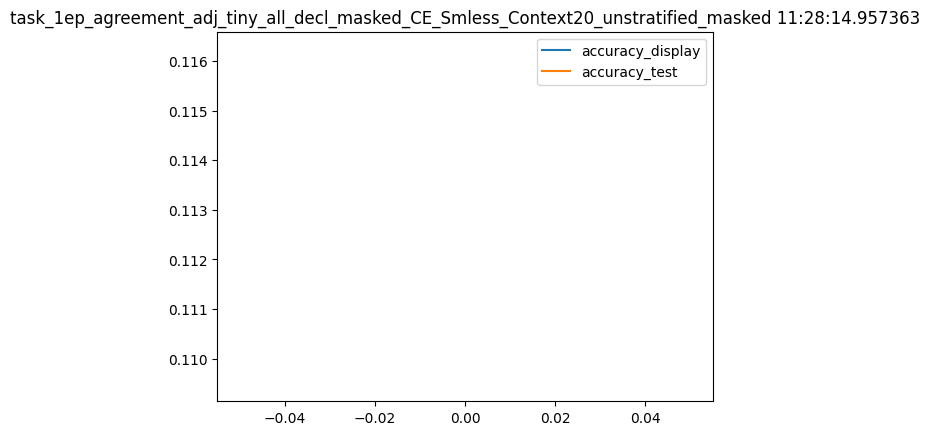

In [15]:
job_name = 'datasphere/agreementproject/job_info/job_agreementproject_11:28:14.957121.txt'
metrics, result_df, y_true, y_pred, tasks = get_training_results(bucket,job_name, project_name)


plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique())), tasks[0]

In [13]:
#

45

In [17]:
job_name = 'datasphere/agreementproject/job_info/job_agreementproject_11:51:40.457516.txt'
metrics, result_df, y_true, y_pred, tasks = get_training_results(bucket,job_name, project_name)


# plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
len(sorted_nums), tasks[0]

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


(15,
 'task_1ep_agreement_adj_mid50_all_decl_masked_CE_Smless_Context20_unstratified 11:51:40.457765')

In [11]:
sorted_nums

[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

fixed

In [12]:
job_name = 'datasphere/agreementproject/job_info/job_agreementproject_16:02:07.357183.txt'
metrics, result_df, y_true, y_pred, tasks = get_training_results(bucket,job_name, project_name)


# plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
# cm = pd.DataFrame(
#     confusion_matrix(y_true, y_pred,
#                         # normalize='true'
#                      ).round(2),
#     columns=[f'pred {decl_end_by_num[n]}' for n in sorted_nums],
#     index=[f'actual {decl_end_by_num[n]}' for n in sorted_nums]
# )
# plot_cm(cm)
# cm = pd.DataFrame(
#     confusion_matrix(y_true, y_pred,
#                         normalize='true'
#                      ).round(2),
#     columns=[f'pred {ending_by_num[n]}({n})' for n in sorted_nums],
#     index=[f'actual {ending_by_num[n]}({n})' for n in sorted_nums]
# )
# plot_cm(cm)


output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl
